In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import FourierBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from joblib import Parallel, delayed
from tqdm import tqdm

C:\Users\sunwoong\AppData\Local\Temp\ipykernel_30004\1557460481.py:13: DeprecationWarning: The module "feature_extraction" is deprecated.Please use "dim_reduction" for FPCAor "feature_construction" for feature construction techniques
  from skfda.preprocessing.dim_reduction.feature_extraction import FPCA


## 레벨에 따른 데이터 재구성

In [115]:
data_dir="currency_integrated_pannel.csv"
data=pd.read_csv(data_dir, encoding=False)
data_syn=pd.read_csv("levelups_panel_20240722.csv",encoding='utf-8')

In [116]:
data_syn

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
0,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,1,2,...,0.0,0.0,0.0,0.0,0.0,2021-11-04,2021-11-04,True,0.009444,1
1,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,2,3,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-04,False,5.426389,1
2,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1
3,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1
4,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466992,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0
2466993,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0
2466994,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0
2466995,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,6,7,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0


In [118]:
data=data[['player_slug','final_currency_usage','final_dia_currency_usage']]
data

,player_slug,final_currency_usage,final_dia_currency_usage
0,2021-10-31T16:01:57.631Z,0,0
1,2021-10-31T16:01:57.631Z,0,0
2,2021-10-31T16:01:57.631Z,0,0
3,2021-10-31T16:01:57.631Z,0,0
4,2021-10-31T16:01:57.631Z,0,0
...,...,...,...
2466992,2022-03-30T14:36:22.522Z,0,0
2466993,2022-03-30T14:36:22.522Z,0,0
2466994,2022-03-30T14:36:22.522Z,0,0
2466995,2022-03-30T14:36:22.522Z,0,0


In [120]:
data_syn['final_currency_usage']=data['final_currency_usage']
data_syn['final_dia_currency_usage']=data['final_dia_currency_usage']


In [121]:
data_syn

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage
0,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,1,2,...,0.0,0.0,0.0,2021-11-04,2021-11-04,True,0.009444,1,0,0
1,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,2,3,...,0.0,0.0,0.0,2021-11-13,2021-11-04,False,5.426389,1,0,0
2,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,3,4,...,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1,0,0
3,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,4,5,...,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1,0,0
4,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,5,6,...,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466992,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,3,4,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0,0,0
2466993,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,4,5,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0,0,0
2466994,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,5,6,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0,0,0
2466995,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,6,7,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0,0,0


In [122]:
data_syn.to_csv('levelups_panel_0902.csv',encoding='utf-8',index=False)

## Binge 및 재화 소비 추가 후 데이터 재구성

In [158]:
data_dir="levelups_panel_0902.csv"
data=pd.read_csv(data_dir, encoding=False)

In [159]:
data_check = data[data['highest_level'] >= 150]
data_check

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage
5469,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,1,2,...,0.000000,0.0,0.0000,2021-11-02,2021-11-02,True,1.498889,1,0,0
5470,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,2,3,...,0.000000,0.0,0.0000,2021-11-02,2021-11-02,True,1.498889,1,0,0
5471,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,3,4,...,0.000000,0.0,0.0000,2021-11-02,2021-11-02,True,1.498889,1,0,0
5472,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,4,5,...,0.000000,0.0,0.0000,2021-11-02,2021-11-02,True,1.498889,1,0,0
5473,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,5,6,...,0.000000,0.0,0.0000,2021-11-02,2021-11-02,True,1.498889,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463008,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,167,168,...,0.000000,0.0,0.0000,2022-03-30,2022-03-30,True,23.513611,1,0,0
2463009,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,168,169,...,0.000000,0.0,0.0000,2022-03-30,2022-03-30,True,23.513611,1,0,0
2463010,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,169,170,...,0.003056,0.0,0.2175,2022-03-30,2022-03-30,True,23.513611,1,0,0
2463011,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,170,171,...,0.000000,0.0,0.0000,2022-03-30,2022-03-30,True,23.513611,1,750000,0


## 레벨 150까지의 synthetic control 추가

In [160]:
#outlier 제거
focal_data = data_check[(data_check['level_to'] <= 150) & (data_check['level_to'] > 100)]
focal_data['prev_interval'] = focal_data.groupby('player_slug')['interval'].shift(1)
focal_data['interval_ratio'] = focal_data.apply(lambda row: row['interval'] / (row['prev_interval'] if pd.notnull(row['prev_interval']) else row['interval']), axis=1)
focal_data.loc[focal_data['interval_ratio'] > 10, 'interval'] = np.nan



C:\Users\sunwoong\AppData\Local\Temp\ipykernel_30004\607822067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focal_data['prev_interval'] = focal_data.groupby('player_slug')['interval'].shift(1)
C:\Users\sunwoong\AppData\Local\Temp\ipykernel_30004\607822067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focal_data['interval_ratio'] = focal_data.apply(lambda row: row['interval'] / (row['prev_interval'] if pd.notnull(row['prev_interval']) else row['interval']), axis=1)


In [161]:
focal_data = focal_data[['player_slug','interval','first_session_level','binge','level_from','level_to','purchase','highest_level',
                   'death','ad_revival','ad_item','playtime_side']]


In [162]:
focal_data['interval'].max()
max_interval_index = focal_data['interval'].idxmax()
max_interval_row = focal_data.loc[max_interval_index]
max_interval_row


player_slug            2021-12-17T12:16:15.655Z
interval                             764.410556
first_session_level                           5
binge                                         0
level_from                                  137
level_to                                    138
purchase                                    0.0
highest_level                               152
death                                       5.0
ad_revival                                  0.0
ad_item                                     0.0
playtime_side                          0.393333
Name: 200921, dtype: object

In [163]:
# interval 열의 결측치 개수 확인
print(focal_data['interval'].isna().sum())

# 결측치가 있는 행 확인
print(focal_data[focal_data['interval'].isna()])
focal_data['level_to'] = focal_data['level_to'].astype(int)

7650
                      player_slug  interval  first_session_level  binge  \
5579     2021-11-02T13:26:32.660Z       NaN                   59      1   
5580     2021-11-02T13:26:32.660Z       NaN                   59      1   
5586     2021-11-02T13:26:32.660Z       NaN                   59      1   
5588     2021-11-02T13:26:32.660Z       NaN                   59      1   
5592     2021-11-02T13:26:32.660Z       NaN                   59      1   
...                           ...       ...                  ...    ...   
2457909  2022-03-22T23:02:07.011Z       NaN                   55      1   
2457916  2022-03-22T23:02:07.011Z       NaN                   55      1   
2457921  2022-03-22T23:02:07.011Z       NaN                   55      1   
2459878  2022-03-24T16:37:29.569Z       NaN                  113      1   
2459903  2022-03-24T16:37:29.569Z       NaN                  113      1   

         level_from  level_to  purchase  highest_level  death  ad_revival  \
5579            1

In [164]:
data_ratio_term = focal_data[['player_slug','binge', 'level_to', 'interval']]
threshold_df = pd.DataFrame(columns=['Column', 'Threshold'])

# 데이터 피벗
pivot_data_ratio = data_ratio_term.pivot_table(index='player_slug', columns='level_to', values='interval', aggfunc='mean')
binge_series = data.drop_duplicates('player_slug').set_index('player_slug')['binge']
pivot_data_ratio = pivot_data_ratio.join(binge_series)
#Remove top 1% value of the interval
columns_to_exclude = ['binge']
for column in pivot_data_ratio.columns:
    # NaN 값을 제외하고 상위 99% 값 계산
    threshold = pivot_data_ratio[column].dropna().quantile(0.975)
    
    pivot_data_ratio.loc[pivot_data_ratio[column] > threshold, column] = np.nan
    # 컬럼명과 threshold 값을 데이터프레임에 추가
    temp_df = pd.DataFrame({'Column': [column], 'Threshold': [threshold]})
    
    # 기존 데이터프레임과 임시 데이터프레임을 결합
    threshold_df = pd.concat([threshold_df, temp_df], ignore_index=True)

pivot_data_reset = pivot_data_ratio.reset_index().melt(id_vars=['player_slug', 'binge'], var_name='level_to', value_name='interval')


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_30004\52882940.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  threshold_df = pd.concat([threshold_df, temp_df], ignore_index=True)


In [165]:
pivot_data_reset

,player_slug,binge,level_to,interval
0,2021-11-02T13:26:32.660Z,1.0,101,0.803889
1,2021-11-07T02:08:43.788Z,0.0,101,1.021111
2,2021-11-07T15:46:35.878Z,1.0,101,0.098889
3,2021-11-09T12:36:41.935Z,0.0,101,0.455278
4,2021-11-10T13:52:38.359Z,1.0,101,0.092778
...,...,...,...,...
46295,2022-03-20T08:23:38.716Z,1.0,150,2.046667
46296,2022-03-22T23:02:07.011Z,1.0,150,0.130833
46297,2022-03-24T16:37:29.569Z,1.0,150,1.329167
46298,2022-03-24T17:09:04.286Z,1.0,150,3.425000


In [166]:
threshold_df

,Column,Threshold
0,101,16.581632
1,102,1.903500
2,103,3.760472
3,104,3.462354
4,105,3.780028
5,106,3.075556
6,107,2.883958
7,108,3.819111
8,109,2.906118
9,110,2.529667


In [167]:
df = threshold_df.drop(threshold_df.index[-1])


In [170]:
pivot_data_ratio.to_csv('0902_outlier_remove.csv',encoding='utf-8')

## 기존 데이터에 아웃라이어 제거한거 병합

In [171]:
import cvxpy as cp
from tqdm import tqdm
#pivot_data_ratio =pd.read_csv("Before_Synthetic.csv",encoding='utf-8')
pivot_data_ratio =pd.read_csv("0902_outlier_remove.csv",encoding='utf-8')
#data_check

In [172]:
# other_data를 before_synthetic에 병합
for i, row in tqdm(data_check.iterrows(), total=data_check.shape[0]):
    player = row['player_slug']
    level_to = str(row['level_to'])
    if player in pivot_data_ratio['player_slug'].values and level_to in pivot_data_ratio.columns:
        data_check.loc[i, 'interval'] = pivot_data_ratio.loc[pivot_data_ratio['player_slug'] == player, level_to].values[0]


100%|██████████| 159334/159334 [00:14<00:00, 11240.49it/s]


In [179]:
data_check.to_csv("0902_before_synthetic.csv", index=False,encoding="utf-8")

## 결측치 Synthetic Control

In [209]:
data=pd.read_csv("0902_before_synthetic.csv",encoding="utf-8")
data = data[data['level_to'] <= 150]

In [210]:
# interval 열의 결측치 개수 확인
print(data['interval'].isna().sum())


8641


In [211]:
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import minimize
import warnings

# 경고 메시지 억제
warnings.filterwarnings("ignore", message="X does not have valid feature names, but NearestNeighbors was fitted with feature names")

def fill_missing_intervals(data,k=5):
    complete_data = data.dropna(subset=['interval'])
    missing_data = data[data['interval'].isnull()]
    
    # level_from과 level_to 외의 다른 feature들을 추가
    features = ['level_to','death','playtime_side','ad_revival','purchase','highest_level','ad_item']
    
    knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn.fit(complete_data[features])

    for index, row in tqdm(missing_data.iterrows(), total=missing_data.shape[0], desc="Filling missing intervals"):
        # feature 값을 2차원 배열로 변환하여 전달
        distances, indices = knn.kneighbors([row[features].values])
        neighbor_intervals = complete_data.iloc[indices[0]]['interval']
        predicted_interval = np.mean(neighbor_intervals)
        
        data.at[index, 'interval'] = predicted_interval
    
    return data

data_filled = fill_missing_intervals(data)


Filling missing intervals: 100%|██████████| 8641/8641 [00:03<00:00, 2305.95it/s]


In [214]:
data_filled

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage
0,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,1,2,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
1,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,2,3,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
2,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,3,4,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
3,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,4,5,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
4,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,5,6,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159307,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,145,146,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,10000000,2
159308,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,146,147,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,0,0
159309,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,147,148,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,0,0
159310,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,148,149,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,0,0


In [215]:
output_file_path = 'levelups_panel_0902_final.csv'
data_filled.to_csv(output_file_path, index=False,encoding='utf-8')

## 기존 코드

In [261]:
data_dir='levelups_panel_0902_final.csv'
data=pd.read_csv(data_dir, encoding=False)

In [262]:
data_check = data[data['highest_level'] >= 150]
data_check

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage
0,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,1,2,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
1,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,2,3,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
2,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,3,4,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
3,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,4,5,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
4,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,5,6,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137969,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,145,146,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,10000000,2
137970,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,146,147,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,0,0
137971,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,147,148,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,0,0
137972,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,148,149,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,0,0


In [263]:
unique_player_slugs = data_check['player_slug'].nunique()
unique_player_slugs

926

In [264]:
data_purchase=data_check[data_check['total_purchase']!=0]

In [265]:
unique_player_slugs = data_purchase['player_slug'].nunique()
unique_player_slugs

366

In [266]:
df_sum = data_check.groupby('player_slug')['final_currency_usage'].sum().reset_index()
df = pd.merge(data_check, df_sum, on='player_slug', suffixes=('', '_total'))
df_sum = data_check.groupby('player_slug')['final_dia_currency_usage'].sum().reset_index()
df = pd.merge(df, df_sum, on='player_slug', suffixes=('', '_total'))

In [267]:
df.columns

Index(['player_slug', 'character_slug', 'first_session_level', 'binger',
       'total_purchase', 'total_ad', 'highest_level', 'status', 'level_from',
       'level_to', 'event_datetime', 'death', 'ad_revival', 'ad_item',
       'ad_total', 'purchase', 'event_datetime_prev', 'interval',
       'interval_cum', 'playtime_boss', 'playtime_dungeon', 'playtime_tower',
       'playtime_pvp', 'playtime_farm', 'playtime_survival', 'playtime_side',
       'date_event', 'date_event_prev', 'same_date', 'date_interval', 'binge',
       'final_currency_usage', 'final_dia_currency_usage',
       'final_currency_usage_total', 'final_dia_currency_usage_total'],
      dtype='object')

In [268]:
data_ratio_term = df[['player_slug','binge','binger', 'level_to', 'interval','total_purchase','total_ad','final_currency_usage_total','final_dia_currency_usage_total']]

# 데이터 피벗
pivot_data_ratio = data_ratio_term.pivot_table(index='player_slug', columns='level_to', values='interval', aggfunc='mean')
binge_series = data_ratio_term.drop_duplicates('player_slug').set_index('player_slug')[['total_ad','total_purchase','final_currency_usage_total','final_dia_currency_usage_total','binge','binger']]
pivot_data_ratio = pivot_data_ratio.join(binge_series)

In [269]:
pivot_data_ratio.to_csv("0902_full_lv150.csv",encoding='utf-8')


In [270]:
data=pd.read_csv("0902_full_lv150.csv",encoding='utf-8')
data

,player_slug,2,3,4,5,6,7,8,9,10,...,147,148,149,150,total_ad,total_purchase,final_currency_usage_total,final_dia_currency_usage_total,binge,binger
0,2021-11-02T13:26:32.660Z,0.011389,0.004722,0.028333,0.013889,0.028333,0.024167,0.021389,0.028333,0.031389,...,1.298222,0.000278,1.477833,0.000278,50.0,0.0,27963000,15481,1,1
1,2021-11-07T02:08:43.788Z,0.010278,0.020833,0.015556,0.018333,0.018056,0.023056,0.025000,0.058611,0.039167,...,4.875167,1.926944,2.045833,2.550278,16.0,0.0,61350600,613,0,1
2,2021-11-07T15:46:35.878Z,0.009167,0.004444,0.007222,0.016944,0.013611,0.023056,0.021944,0.026667,0.030556,...,0.014167,0.109722,0.065000,0.003889,1.0,416900.0,20050000,121759,1,1
3,2021-11-09T12:36:41.935Z,0.010556,0.005833,0.033889,0.032778,0.042778,0.032222,0.022778,0.026944,0.032222,...,2.786389,3.061111,3.741944,0.077222,17.0,13200.0,5500700,14863,0,1
4,2021-11-10T13:52:38.359Z,0.010000,0.003889,0.006389,0.014444,0.013333,0.026111,0.030833,0.026389,0.033056,...,1.551667,1.634722,2.828889,1.571111,3.0,0.0,71800600,116,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,2022-03-20T08:23:38.716Z,0.036111,0.004722,0.009444,0.012778,0.015278,0.021111,0.053611,0.029167,0.125000,...,1.650556,1.713889,2.626667,2.046667,97.0,0.0,56100100,13821,1,1
922,2022-03-22T23:02:07.011Z,0.012500,0.009167,0.013333,0.017222,0.060000,0.024444,0.030278,0.032222,0.043556,...,5.938278,0.036944,0.195833,0.130833,52.0,0.0,48801000,19777,1,1
923,2022-03-24T16:37:29.569Z,0.008333,0.003611,0.009444,0.008889,0.020278,0.024167,0.028056,0.034167,0.037500,...,2.911944,3.081667,2.874722,1.329167,11.0,23100.0,26050600,8657,1,1
924,2022-03-24T17:09:04.286Z,0.019722,0.012500,0.034167,0.026667,0.014722,0.023944,0.025278,0.027778,0.036389,...,4.371111,4.783333,3.266944,3.425000,18.0,0.0,125200000,3100,1,1


In [271]:

cols_to_keep = list(data.columns[:150])
binge_data=data[['player_slug','binger']]
additional_cols = ['total_ad','total_purchase','final_currency_usage_total','final_dia_currency_usage_total','binge']
# 앞 150개의 컬럼과 특정 컬럼들을 결합
cols_to_keep.extend(additional_cols)

# 해당 컬럼들만 남기고 나머지 컬럼 삭제
data = data[cols_to_keep]
data

,player_slug,2,3,4,5,6,7,8,9,10,...,146,147,148,149,150,total_ad,total_purchase,final_currency_usage_total,final_dia_currency_usage_total,binge
0,2021-11-02T13:26:32.660Z,0.011389,0.004722,0.028333,0.013889,0.028333,0.024167,0.021389,0.028333,0.031389,...,0.000278,1.298222,0.000278,1.477833,0.000278,50.0,0.0,27963000,15481,1
1,2021-11-07T02:08:43.788Z,0.010278,0.020833,0.015556,0.018333,0.018056,0.023056,0.025000,0.058611,0.039167,...,0.005556,4.875167,1.926944,2.045833,2.550278,16.0,0.0,61350600,613,0
2,2021-11-07T15:46:35.878Z,0.009167,0.004444,0.007222,0.016944,0.013611,0.023056,0.021944,0.026667,0.030556,...,0.058889,0.014167,0.109722,0.065000,0.003889,1.0,416900.0,20050000,121759,1
3,2021-11-09T12:36:41.935Z,0.010556,0.005833,0.033889,0.032778,0.042778,0.032222,0.022778,0.026944,0.032222,...,3.192778,2.786389,3.061111,3.741944,0.077222,17.0,13200.0,5500700,14863,0
4,2021-11-10T13:52:38.359Z,0.010000,0.003889,0.006389,0.014444,0.013333,0.026111,0.030833,0.026389,0.033056,...,1.492222,1.551667,1.634722,2.828889,1.571111,3.0,0.0,71800600,116,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,2022-03-20T08:23:38.716Z,0.036111,0.004722,0.009444,0.012778,0.015278,0.021111,0.053611,0.029167,0.125000,...,1.634722,1.650556,1.713889,2.626667,2.046667,97.0,0.0,56100100,13821,1
922,2022-03-22T23:02:07.011Z,0.012500,0.009167,0.013333,0.017222,0.060000,0.024444,0.030278,0.032222,0.043556,...,0.878611,5.938278,0.036944,0.195833,0.130833,52.0,0.0,48801000,19777,1
923,2022-03-24T16:37:29.569Z,0.008333,0.003611,0.009444,0.008889,0.020278,0.024167,0.028056,0.034167,0.037500,...,1.093333,2.911944,3.081667,2.874722,1.329167,11.0,23100.0,26050600,8657,1
924,2022-03-24T17:09:04.286Z,0.019722,0.012500,0.034167,0.026667,0.014722,0.023944,0.025278,0.027778,0.036389,...,6.081944,4.371111,4.783333,3.266944,3.425000,18.0,0.0,125200000,3100,1


In [248]:
binge_data

,player_slug,binge
0,2021-11-02T13:26:32.660Z,1
1,2021-11-07T02:08:43.788Z,0
2,2021-11-07T15:46:35.878Z,1
3,2021-11-09T12:36:41.935Z,0
4,2021-11-10T13:52:38.359Z,1
...,...,...
921,2022-03-20T08:23:38.716Z,1
922,2022-03-22T23:02:07.011Z,1
923,2022-03-24T16:37:29.569Z,1
924,2022-03-24T17:09:04.286Z,1


## LOESS 기반 클러스터링

c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


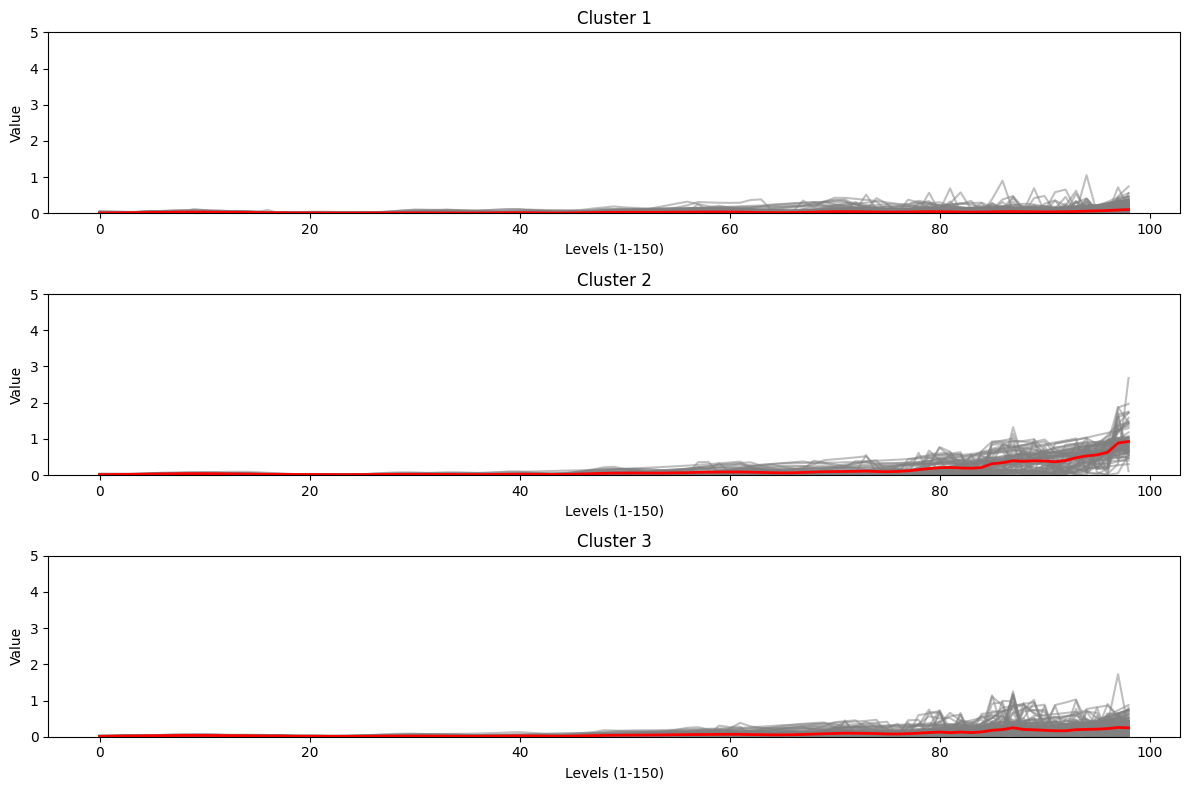

In [353]:
import pywt
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data=pd.read_csv("0902_full_lv150.csv",encoding='utf-8')

cols_to_keep = list(data.columns[:150])
additional_cols = ['total_ad','total_purchase','final_currency_usage_total','final_dia_currency_usage_total','binger']
# 앞 150개의 컬럼과 특정 컬럼들을 결합
cols_to_keep.extend(additional_cols)

# 해당 컬럼들만 남기고 나머지 컬럼 삭제
data = data[cols_to_keep]


# 웨이블릿 변환을 위한 데이터 선택 (2번 열부터 100번 열까지)
curves_data = data.iloc[:, 1:100].values  # 2번 열부터 100번 열까지 선택

# LOESS 적용 함수 정의
def apply_loess(curve, frac=0.1):
    """
    curve: 원본 곡선 데이터 (1차원 배열)
    frac: LOESS에서 사용하는 로컬 윈도우 크기 (0에서 1 사이의 값)
    """
    x = np.arange(len(curve))  # x축 데이터 포인트 생성 (1, 2, 3, ..., N)
    loess_result = sm.nonparametric.lowess(curve, x, frac=frac)  # LOESS 적용
    return loess_result[:, 1]  # 평활화된 y값 반환

# 각 곡선에 LOESS 적용
loess_curves = np.array([apply_loess(curve, frac=0.1) for curve in curves_data])

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42)
labels_loess = kmeans.fit_predict(loess_curves)
data['cluster'] = labels_loess

# 클러스터 결과 시각화
plt.figure(figsize=(12, 8))

for cluster in range(3):  # 각 클러스터에 대해 반복
    plt.subplot(3, 1, cluster + 1)
    for curve in loess_curves[labels_loess == cluster]:  # 해당 클러스터의 곡선들을 그리기
        plt.plot(curve, color='gray', alpha=0.5)
    plt.plot(loess_curves[labels_loess == cluster].mean(axis=0), color='red', linewidth=2)  # 평균 곡선
    plt.title(f'Cluster {cluster + 1}')
    plt.xlabel('Levels (1-150)')
    plt.ylabel('Value')
    plt.ylim(0, 5)  # 필요시 Y축 범위 조정

plt.tight_layout()
plt.show()

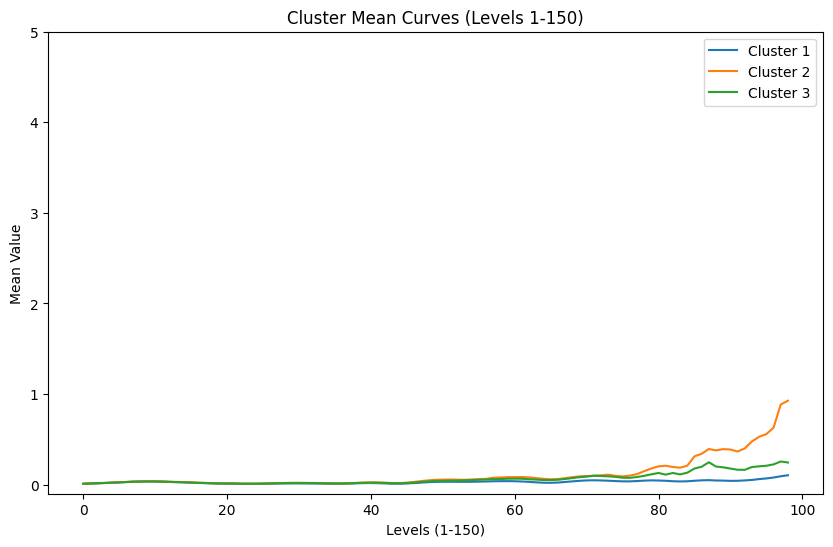

In [354]:
# 클러스터별 평균 곡선을 하나의 그래프로 시각화
plt.figure(figsize=(10, 6))

for cluster in range(3):  # 각 클러스터에 대해 반복
    mean_curve = loess_curves[labels_loess == cluster].mean(axis=0)
    plt.plot(mean_curve, label=f'Cluster {cluster + 1}')

plt.title('Cluster Mean Curves (Levels 1-150)')
plt.xlabel('Levels (1-150)')
plt.ylabel('Mean Value')
plt.ylim(-0.1, 5)  # 필요시 Y축 범위 조정
plt.legend()
plt.show()

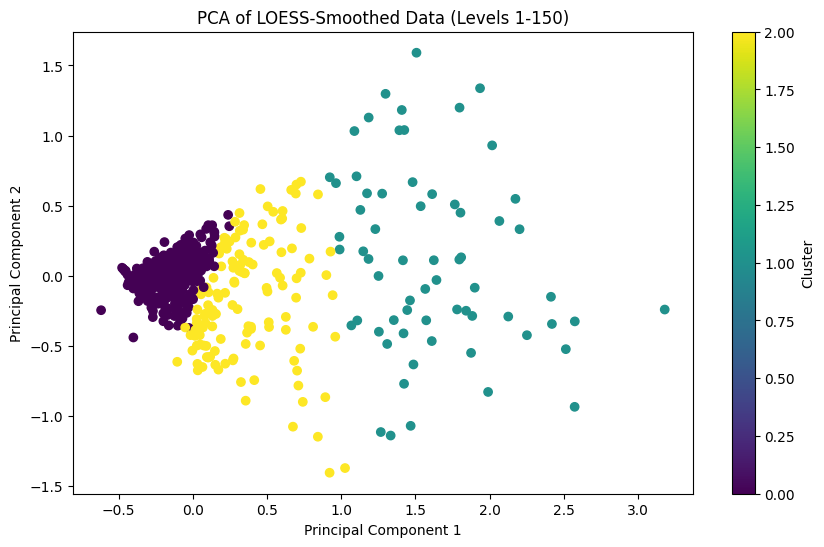

Explained Variance by Component 1: 0.55
Explained Variance by Component 2: 0.14


In [355]:
# PCA 분석 수행
pca = PCA(n_components=3)
pca_result = pca.fit_transform(loess_curves)

# PCA 결과 시각화 (클러스터별)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_loess, cmap='viridis')
plt.title('PCA of LOESS-Smoothed Data (Levels 1-150)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# PCA 설명력 (Variance Explained)
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by Component 1: {explained_variance[0]:.2f}")
print(f"Explained Variance by Component 2: {explained_variance[1]:.2f}")

In [288]:

# Cluster별로 그룹화하여 'binge' 열의 비율을 계산
binge_ratios = data.groupby('cluster')['binger'].value_counts(normalize=True).unstack()

# 결과 확인
print(binge_ratios)
binge_number = data.groupby('cluster')['binger'].value_counts().unstack()

# 결과 확인
print(binge_number)

binger          0         1
cluster                    
0        0.358413  0.641587
1        0.338462  0.661538
2        0.307692  0.692308
binger     0    1
cluster          
0        262  469
1         22   43
2         40   90


## wavelet 방식

In [359]:
data=pd.read_csv("0902_full_lv150.csv",encoding='utf-8')

cols_to_keep = list(data.columns[:150])
additional_cols = ['total_ad','total_purchase','final_currency_usage_total','final_dia_currency_usage_total','binge','binger']
# 앞 150개의 컬럼과 특정 컬럼들을 결합
cols_to_keep.extend(additional_cols)

# 해당 컬럼들만 남기고 나머지 컬럼 삭제
data = data[cols_to_keep]
data

,player_slug,2,3,4,5,6,7,8,9,10,...,147,148,149,150,total_ad,total_purchase,final_currency_usage_total,final_dia_currency_usage_total,binge,binger
0,2021-11-02T13:26:32.660Z,0.011389,0.004722,0.028333,0.013889,0.028333,0.024167,0.021389,0.028333,0.031389,...,1.298222,0.000278,1.477833,0.000278,50.0,0.0,27963000,15481,1,1
1,2021-11-07T02:08:43.788Z,0.010278,0.020833,0.015556,0.018333,0.018056,0.023056,0.025000,0.058611,0.039167,...,4.875167,1.926944,2.045833,2.550278,16.0,0.0,61350600,613,0,1
2,2021-11-07T15:46:35.878Z,0.009167,0.004444,0.007222,0.016944,0.013611,0.023056,0.021944,0.026667,0.030556,...,0.014167,0.109722,0.065000,0.003889,1.0,416900.0,20050000,121759,1,1
3,2021-11-09T12:36:41.935Z,0.010556,0.005833,0.033889,0.032778,0.042778,0.032222,0.022778,0.026944,0.032222,...,2.786389,3.061111,3.741944,0.077222,17.0,13200.0,5500700,14863,0,1
4,2021-11-10T13:52:38.359Z,0.010000,0.003889,0.006389,0.014444,0.013333,0.026111,0.030833,0.026389,0.033056,...,1.551667,1.634722,2.828889,1.571111,3.0,0.0,71800600,116,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,2022-03-20T08:23:38.716Z,0.036111,0.004722,0.009444,0.012778,0.015278,0.021111,0.053611,0.029167,0.125000,...,1.650556,1.713889,2.626667,2.046667,97.0,0.0,56100100,13821,1,1
922,2022-03-22T23:02:07.011Z,0.012500,0.009167,0.013333,0.017222,0.060000,0.024444,0.030278,0.032222,0.043556,...,5.938278,0.036944,0.195833,0.130833,52.0,0.0,48801000,19777,1,1
923,2022-03-24T16:37:29.569Z,0.008333,0.003611,0.009444,0.008889,0.020278,0.024167,0.028056,0.034167,0.037500,...,2.911944,3.081667,2.874722,1.329167,11.0,23100.0,26050600,8657,1,1
924,2022-03-24T17:09:04.286Z,0.019722,0.012500,0.034167,0.026667,0.014722,0.023944,0.025278,0.027778,0.036389,...,4.371111,4.783333,3.266944,3.425000,18.0,0.0,125200000,3100,1,1


In [360]:
# 각 곡선에 웨이블릿 변환 적용
curves_data = data.iloc[:, 1:130].values  # 2번 열부터 100번 열까지 선택

coeffs = [pywt.wavedec(curve, 'db4', level=4) for curve in curves_data]
# 모든 웨이블릿 계수를 하나의 배열로 병합
coeffs_flat = np.array([np.concatenate(c) for c in coeffs])

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(coeffs_flat)

# 클러스터 레이블을 원본 데이터에 추가
data['cluster'] = labels

c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


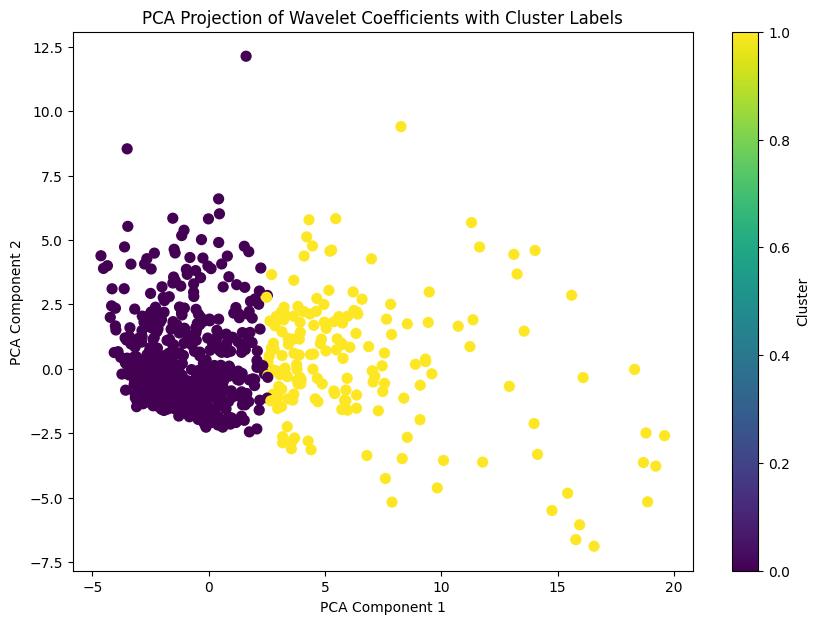

array([0.42442019, 0.09621186, 0.07745138])

In [361]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA를 사용하여 데이터를 2차원으로 축소
pca = PCA(n_components=3)
coeffs_pca = pca.fit_transform(coeffs_flat)

# 클러스터 결과를 2차원 공간에 시각화
plt.figure(figsize=(10, 7))
plt.scatter(coeffs_pca[:, 0], coeffs_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title('PCA Projection of Wavelet Coefficients with Cluster Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# PCA 설명력 (Variance Explained)
explained_variance = pca.explained_variance_ratio_
explained_variance

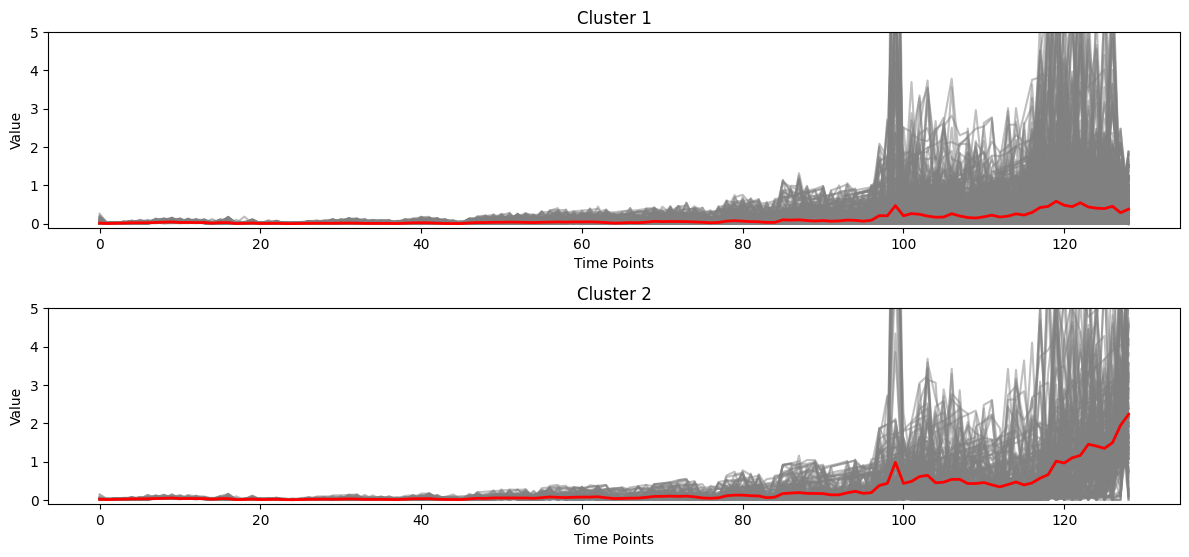

In [362]:
# 클러스터별 곡선 시각화
plt.figure(figsize=(12, 8))

for cluster in range(2):  # 각 클러스터에 대해 반복
    plt.subplot(3, 1, cluster + 1)
    for curve in curves_data[labels == cluster]:
        plt.plot(curve, color='gray', alpha=0.5)  # 개별 곡선
    plt.plot(curves_data[labels == cluster].mean(axis=0), color='red', linewidth=2)  # 평균 곡선
    plt.title(f'Cluster {cluster + 1}')
    plt.xlabel('Time Points')
    plt.ylabel('Value')
    plt.ylim(-0.1, 5)

plt.tight_layout()
plt.show()


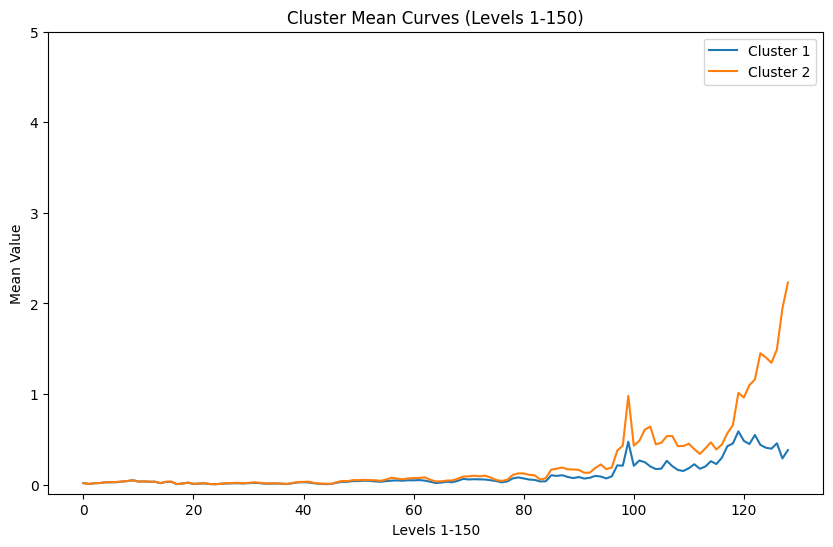

In [363]:
# 클러스터별 평균 곡선을 하나의 그래프로 시각화
plt.figure(figsize=(10, 6))

for cluster in range(2):  # 각 클러스터에 대해 반복
    mean_curve = curves_data[labels == cluster].mean(axis=0)
    plt.plot(mean_curve, label=f'Cluster {cluster + 1}')

plt.title('Cluster Mean Curves (Levels 1-150)')
plt.xlabel('Levels 1-150')
plt.ylabel('Mean Value')
plt.ylim(-0.1, 5)  # 필요시 Y축 범위 조정
plt.legend()
plt.show()

In [365]:

# Cluster별로 그룹화하여 'binge' 열의 비율을 계산
binge_ratios = data.groupby('cluster')['binger'].value_counts(normalize=True).unstack()

# 결과 확인
print(binge_ratios)
binge_number = data.groupby('cluster')['binger'].value_counts().unstack()

# 결과 확인
print(binge_number)

binger          0         1
cluster                    
0        0.348806  0.651194
1        0.354651  0.645349
binger     0    1
cluster          
0        263  491
1         61  111


## 뒷 레벨의 결과 prediction

In [366]:
data

,player_slug,2,3,4,5,6,7,8,9,10,...,148,149,150,total_ad,total_purchase,final_currency_usage_total,final_dia_currency_usage_total,binge,binger,cluster
0,2021-11-02T13:26:32.660Z,0.011389,0.004722,0.028333,0.013889,0.028333,0.024167,0.021389,0.028333,0.031389,...,0.000278,1.477833,0.000278,50.0,0.0,27963000,15481,1,1,0
1,2021-11-07T02:08:43.788Z,0.010278,0.020833,0.015556,0.018333,0.018056,0.023056,0.025000,0.058611,0.039167,...,1.926944,2.045833,2.550278,16.0,0.0,61350600,613,0,1,0
2,2021-11-07T15:46:35.878Z,0.009167,0.004444,0.007222,0.016944,0.013611,0.023056,0.021944,0.026667,0.030556,...,0.109722,0.065000,0.003889,1.0,416900.0,20050000,121759,1,1,0
3,2021-11-09T12:36:41.935Z,0.010556,0.005833,0.033889,0.032778,0.042778,0.032222,0.022778,0.026944,0.032222,...,3.061111,3.741944,0.077222,17.0,13200.0,5500700,14863,0,1,1
4,2021-11-10T13:52:38.359Z,0.010000,0.003889,0.006389,0.014444,0.013333,0.026111,0.030833,0.026389,0.033056,...,1.634722,2.828889,1.571111,3.0,0.0,71800600,116,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,2022-03-20T08:23:38.716Z,0.036111,0.004722,0.009444,0.012778,0.015278,0.021111,0.053611,0.029167,0.125000,...,1.713889,2.626667,2.046667,97.0,0.0,56100100,13821,1,1,1
922,2022-03-22T23:02:07.011Z,0.012500,0.009167,0.013333,0.017222,0.060000,0.024444,0.030278,0.032222,0.043556,...,0.036944,0.195833,0.130833,52.0,0.0,48801000,19777,1,1,0
923,2022-03-24T16:37:29.569Z,0.008333,0.003611,0.009444,0.008889,0.020278,0.024167,0.028056,0.034167,0.037500,...,3.081667,2.874722,1.329167,11.0,23100.0,26050600,8657,1,1,0
924,2022-03-24T17:09:04.286Z,0.019722,0.012500,0.034167,0.026667,0.014722,0.023944,0.025278,0.027778,0.036389,...,4.783333,3.266944,3.425000,18.0,0.0,125200000,3100,1,1,1


In [367]:
# 150레벨 클러스터링
# 각 곡선에 웨이블릿 변환 적용
curves_data = data.iloc[:, 1:100].values  # 2번 열부터 100번 열까지 선택

coeffs = [pywt.wavedec(curve, 'db4', level=4) for curve in curves_data]
# 모든 웨이블릿 계수를 하나의 배열로 병합
coeffs_flat = np.array([np.concatenate(c) for c in coeffs])

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(coeffs_flat)

# 클러스터 레이블을 원본 데이터에 추가
data['cluster_lv100'] = labels

c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


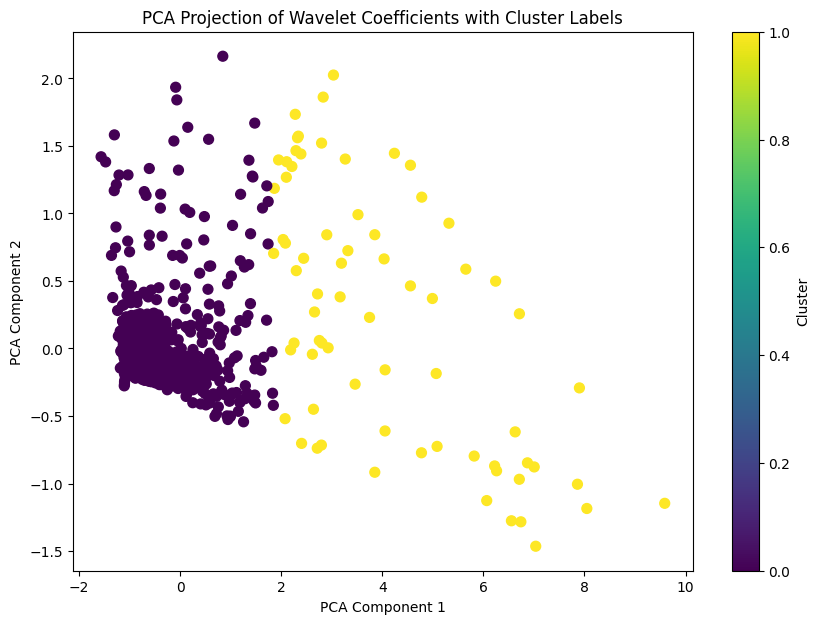

array([0.74078828, 0.06524106, 0.03653979])

In [368]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA를 사용하여 데이터를 2차원으로 축소
pca = PCA(n_components=3)
coeffs_pca = pca.fit_transform(coeffs_flat)

# 클러스터 결과를 2차원 공간에 시각화
plt.figure(figsize=(10, 7))
plt.scatter(coeffs_pca[:, 0], coeffs_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title('PCA Projection of Wavelet Coefficients with Cluster Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# PCA 설명력 (Variance Explained)
explained_variance = pca.explained_variance_ratio_
explained_variance

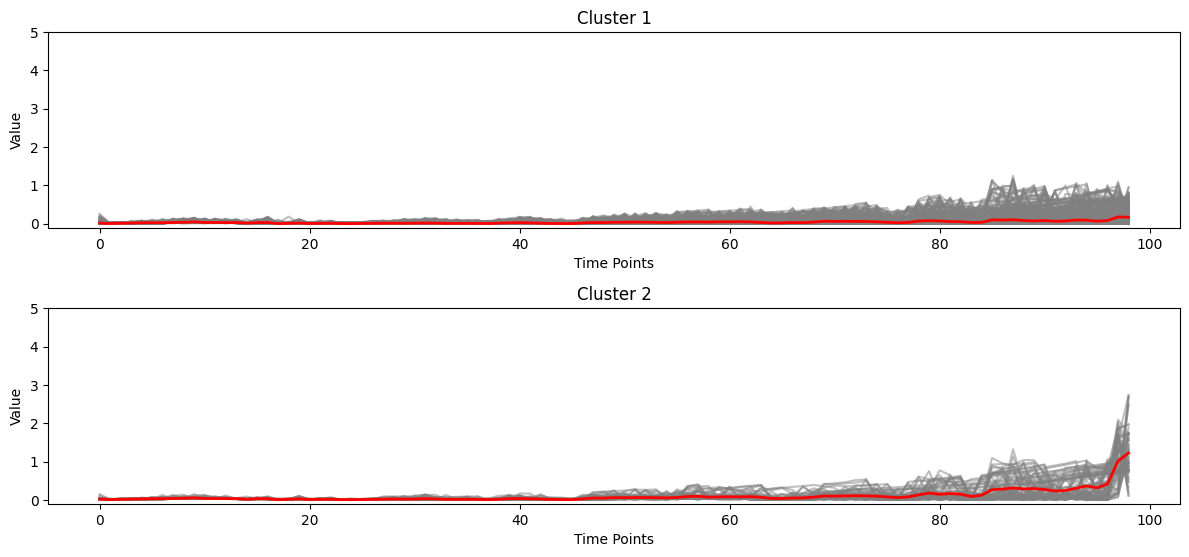

In [369]:
# 클러스터별 곡선 시각화
plt.figure(figsize=(12, 8))

for cluster in range(2):  # 각 클러스터에 대해 반복
    plt.subplot(3, 1, cluster + 1)
    for curve in curves_data[labels == cluster]:
        plt.plot(curve, color='gray', alpha=0.5)  # 개별 곡선
    plt.plot(curves_data[labels == cluster].mean(axis=0), color='red', linewidth=2)  # 평균 곡선
    plt.title(f'Cluster {cluster + 1}')
    plt.xlabel('Time Points')
    plt.ylabel('Value')
    plt.ylim(-0.1, 5)

plt.tight_layout()
plt.show()


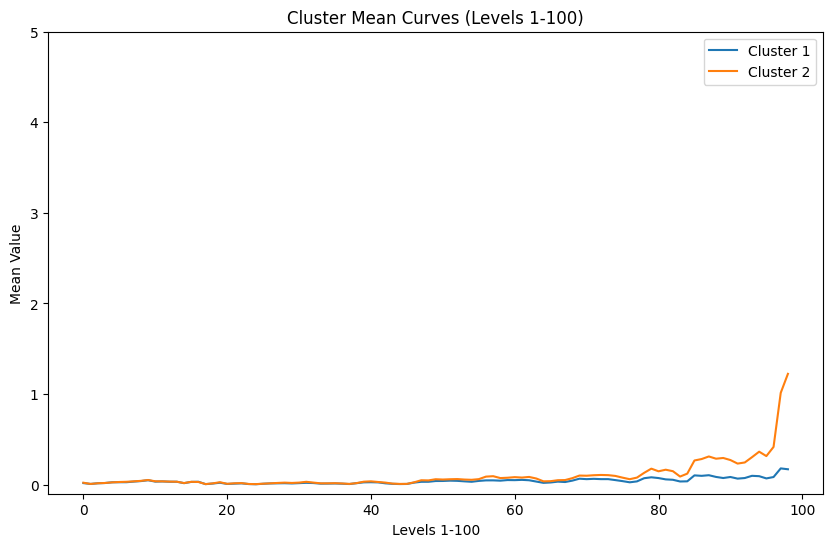

In [370]:
# 클러스터별 평균 곡선을 하나의 그래프로 시각화
plt.figure(figsize=(10, 6))

for cluster in range(2):  # 각 클러스터에 대해 반복
    mean_curve = curves_data[labels == cluster].mean(axis=0)
    plt.plot(mean_curve, label=f'Cluster {cluster + 1}')

plt.title('Cluster Mean Curves (Levels 1-100)')
plt.xlabel('Levels 1-100')
plt.ylabel('Mean Value')
plt.ylim(-0.1, 5)  # 필요시 Y축 범위 조정
plt.legend()
plt.show()

In [337]:
data.to_csv("0902_prediction.csv",index=False,encoding='utf-8')

In [338]:
data

,player_slug,2,3,4,5,6,7,8,9,10,...,149,150,total_ad,total_purchase,final_currency_usage_total,final_dia_currency_usage_total,binge,binger,cluster,cluster_lv100
0,2021-11-02T13:26:32.660Z,0.011389,0.004722,0.028333,0.013889,0.028333,0.024167,0.021389,0.028333,0.031389,...,1.477833,0.000278,50.0,0.0,27963000,15481,1,1,1,1
1,2021-11-07T02:08:43.788Z,0.010278,0.020833,0.015556,0.018333,0.018056,0.023056,0.025000,0.058611,0.039167,...,2.045833,2.550278,16.0,0.0,61350600,613,0,1,0,0
2,2021-11-07T15:46:35.878Z,0.009167,0.004444,0.007222,0.016944,0.013611,0.023056,0.021944,0.026667,0.030556,...,0.065000,0.003889,1.0,416900.0,20050000,121759,1,1,1,0
3,2021-11-09T12:36:41.935Z,0.010556,0.005833,0.033889,0.032778,0.042778,0.032222,0.022778,0.026944,0.032222,...,3.741944,0.077222,17.0,13200.0,5500700,14863,0,1,0,0
4,2021-11-10T13:52:38.359Z,0.010000,0.003889,0.006389,0.014444,0.013333,0.026111,0.030833,0.026389,0.033056,...,2.828889,1.571111,3.0,0.0,71800600,116,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,2022-03-20T08:23:38.716Z,0.036111,0.004722,0.009444,0.012778,0.015278,0.021111,0.053611,0.029167,0.125000,...,2.626667,2.046667,97.0,0.0,56100100,13821,1,1,0,0
922,2022-03-22T23:02:07.011Z,0.012500,0.009167,0.013333,0.017222,0.060000,0.024444,0.030278,0.032222,0.043556,...,0.195833,0.130833,52.0,0.0,48801000,19777,1,1,1,0
923,2022-03-24T16:37:29.569Z,0.008333,0.003611,0.009444,0.008889,0.020278,0.024167,0.028056,0.034167,0.037500,...,2.874722,1.329167,11.0,23100.0,26050600,8657,1,1,0,0
924,2022-03-24T17:09:04.286Z,0.019722,0.012500,0.034167,0.026667,0.014722,0.023944,0.025278,0.027778,0.036389,...,3.266944,3.425000,18.0,0.0,125200000,3100,1,1,0,1


In [371]:
features_to_use = list(data.columns[1:101]) + [
    'total_ad', 'total_purchase', 'final_currency_usage_total',
    'final_dia_currency_usage_total', 'binger','cluster_lv100'
]
X = data[features_to_use]
y = data['cluster']

In [372]:
import pandas as pd
import numpy as np
import pywt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# 훈련/검증/테스트 데이터 분할
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# 랜덤 포레스트 모델 훈련
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 검증 데이터에 대해 예측 수행
y_valid_pred = model.predict(X_valid)

# 검증 데이터 예측 결과 평가
print("Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred))

# 테스트 데이터에 대해 예측 수행
y_test_pred = model.predict(X_test)

# 테스트 데이터 예측 결과 평가
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       153
           1       0.40      0.12      0.19        32

    accuracy                           0.82       185
   macro avg       0.62      0.54      0.54       185
weighted avg       0.76      0.82      0.77       185

Test Set Performance:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       155
           1       0.29      0.06      0.11        31

    accuracy                           0.82       186
   macro avg       0.56      0.52      0.50       186
weighted avg       0.75      0.82      0.77       186

